<a href="https://colab.research.google.com/github/SalhaAlzahrani/KD_TripartiteAtten/blob/main/_KonwledgeDistillation_TransfomerTripartite_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟢  Knowledge Distillation in Transformers with Tripartite Attention: Multiclass Brain Tumor Detection in Highly Augmented MRIs


In [ ]:
!pip install -U -q tensorflow-addons
!pip install nest_asyncio
!pip install keras-cv tensorflow --upgrade

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pathlib
import glob
import keras_cv
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
import math

from google.colab import drive
# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)

import nest_asyncio

Using TensorFlow backend
Mounted at /content/drive


## Hyperparameters

In [ ]:
IMG_SIZE = 224 # We'll resize input images to this size.
input_shape = (224, 224, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
dropout_rate = 0.2
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256
# AUGMENTATION
PATCH_SIZE = 6
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [ ]:
def plot_training_curves(history, title, model_name=''):
    if (model_name == 'teacher'):
      loss = np.array(history.history['loss'])
      val_loss = np.array(history.history['val_loss'])
      epochs = range(len(history.history['loss']))
    else:
      loss = np.array(history.history['student_loss'])
      val_loss = np.array(history.history['val_student_loss'])
      epochs = range(len(history.history['student_loss']))
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    plt.style.use('fivethirtyeight')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.patch.set_facecolor('xkcd:white')

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.', )
    ax1.plot(epochs, val_loss, label='val_loss', marker='.', )
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+title, fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.legend()

    # Plot accuracy
    ax2.set_ylim(ymin=0, ymax=1.1)
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+title, fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.legend()

In [ ]:
def visualize_dataset(dataset, title):
  plt.figure(figsize=(10, 10)).suptitle(title, fontsize=18)
  for images, labels in iter(dataset.take(9)):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img = tf.image.rgb_to_grayscale(images[i])
      plt.imshow(img, cmap='bone')
      ax.grid()
      plt.axis("off")

# Construct Distiller() class





In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        #x, y = data
        x = data[:][0] # get the 0th column of all rows
        y = data[:][1] # get the 1st column of all rows
        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)
            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        #x, y = data
        x = data[:][0] # get the 0th column of all rows
        y = data[:][1] # get the 1st column of all rows
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

#run_experiment module

In [ ]:
from keras.src.callbacks import LearningRateScheduler
def run_experiment(training_dataset, validation_dataset, model, model_name=''):
    # Create LAMB optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile the model.
    if(model_name == 'teacher'):
      model.compile(
          optimizer=optimizer,
          loss=keras.losses.CategoricalCrossentropy(from_logits=True),
          metrics=[
              keras.metrics.CategoricalAccuracy(name="accuracy"),
              keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
              keras.metrics.MeanSquaredError(name='Brier score'),
              keras.metrics.AUC(name='auc'),
          ],
      )
      # Create a learning rate scheduler callback.
      reduce_lr = keras.callbacks.ReduceLROnPlateau(
          monitor="val_loss", factor=0.2, patience=3
      )
      # Create an early stopping callback.
      early_stopping = tf.keras.callbacks.EarlyStopping(
          monitor="val_loss", patience=15, restore_best_weights=True
      )
    else:
      distiller.compile(
          optimizer=keras.optimizers.Adam(),
          metrics=[
              keras.metrics.CategoricalAccuracy(name="accuracy"),
              keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
              keras.metrics.MeanSquaredError(name='Brier score'),
              keras.metrics.AUC(name='auc'),
          ],
          student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
          distillation_loss_fn=keras.losses.KLDivergence(),
          alpha=0.1,
          temperature=10,
      )
      # Create a learning rate scheduler callback.
      reduce_lr = keras.callbacks.ReduceLROnPlateau(
          monitor="student_loss", factor=0.2, patience=3
      )
      # Create an early stopping callback.
      early_stopping = tf.keras.callbacks.EarlyStopping(
          monitor="student_loss", patience=15, restore_best_weights=True
      )

    # Fit the model.
    history = model.fit(
        training_dataset,
        validation_data = validation_dataset,
        batch_size=batch_size,
        epochs=num_epochs,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
    )
    # Return history to plot learning curves.
    return history

# 📂 Load BTDS-15C

In [ ]:
##################
NUM_CLASSES = 15
##################
path = '/content/drive/MyDrive/Multiclass_Brain_Tumor_MRI/MRI_15Classes/'
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 4455 files belonging to 15 classes.
Using 3564 files for training.
Found 4455 files belonging to 15 classes.
Using 891 files for validation.


In [ ]:
#label_mode='categorical',
train_ds_cat = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_cat.class_names
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
class_weights=compute_class_weight(class_weight="balanced",classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 4455 files belonging to 15 classes.


{0: 0.512183908045977,
 1: 1.1835325365205844,
 2: 1.9804444444444445,
 3: 7.817543859649123,
 4: 2.970666666666667,
 5: 1.4562091503267973,
 6: 3.8085470085470083,
 7: 2.267684478371501,
 8: 0.3398932112890923,
 9: 0.650036469730124,
 10: 0.5690932311621967,
 11: 1.3261904761904761,
 12: 1.2534458509142052,
 13: 0.6388530465949821,
 14: 2.048735632183908}

# 🅰 Data augmentation



In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

augmix = keras_cv.layers.AugMix([0, 255])
mixup = keras_cv.layers.MixUp()
cutmix = keras_cv.layers.CutMix(alpha=0.02)

#No augmentation
train_ds_v = train_ds.map(to_dict)
train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds_v = train_ds_v.prefetch(AUTOTUNE)
val_ds_v = val_ds.map(to_dict)
val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
val_ds_v = val_ds_v.prefetch(AUTOTUNE) #Use this for fit

In [ ]:
def aug_pipeline1(samples):
    samples = augmix(samples, training=True)
    return samples
def aug_pipeline2(samples):
    samples = mixup(samples, training=True)
    return samples
def aug_pipeline3(samples):
    samples = cutmix(samples, training=True)
    return samples
def aug_pipeline(samples):
    samples = augmix(samples, training=True)
    samples = mixup(samples, training=True)
    samples = cutmix(samples, training=True)
    return samples
#AugMix
augmix_ds = train_ds.shuffle(1000).map(to_dict)
augmix_ds = augmix_ds.map(aug_pipeline1)
augmix_ds = augmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augmix_ds = augmix_ds.prefetch(AUTOTUNE) #Use this for fit
#MixUp
mixup_ds = train_ds.shuffle(1000).map(to_dict)
mixup_ds = mixup_ds.map(aug_pipeline2)
mixup_ds = mixup_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
mixup_ds = mixup_ds.prefetch(AUTOTUNE) #Use this for fit
#CutMix
cutmix_ds = train_ds.shuffle(1000).map(to_dict)
cutmix_ds = cutmix_ds.map(aug_pipeline3)
cutmix_ds = cutmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
cutmix_ds = cutmix_ds.prefetch(AUTOTUNE) #Use this for fit
#AugPip
augpip_ds = train_ds.shuffle(1000).map(to_dict)
augpip_ds = augpip_ds.map(aug_pipeline)
augpip_ds = augpip_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augpip_ds = augpip_ds.prefetch(AUTOTUNE) #Use this for fit



---



# 🔴 Transformer



In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

<Figure size 1000x1000 with 0 Axes>

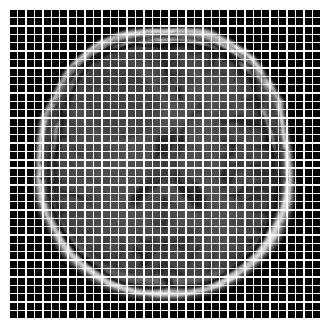

ORIGINAL


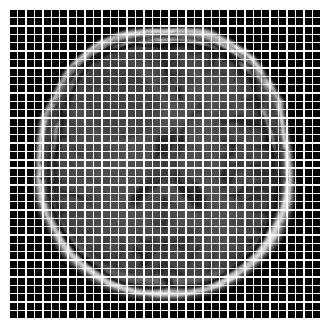

LEFT-UP


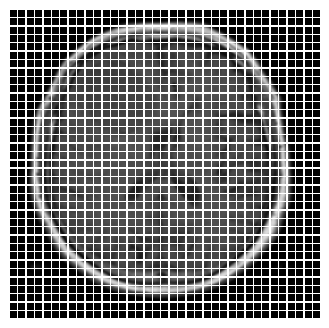

LEFT-DOWN


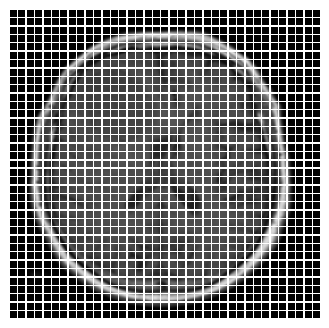

RIGHT-UP


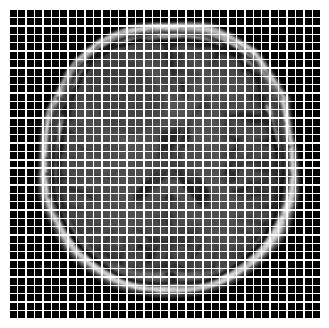

RIGHT-DOWN


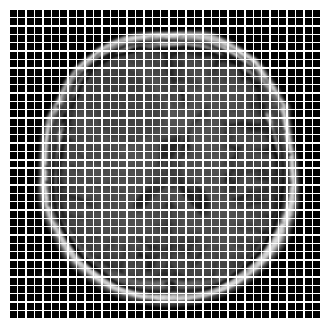

In [ ]:
# Get a random image from the training dataset
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  img = image[0]
# and resize the image
resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(IMG_SIZE, IMG_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    """
    Base class for all attention layers. It contains the common functionality of all attention layers.
    This layer contains a MultiHeadAttention layer, a LayerNormalization layer and an Add layer.
    It is used as a base class for the GlobalSelfAttention, CausalSelfAttention and CrossAttention layers.
    And it is not intended to be used directly.
    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def __init__(self, **kwargs: dict):
        """ Constructor of the BaseAttention layer.
        Args:
            **kwargs: Additional keyword arguments that are passed to the MultiHeadAttention layer, e. g.
                        num_heads (number of heads), key_dim (dimensionality of the key space), etc.
        """
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    """
    A class that implements the cross-attention layer by inheriting from the BaseAttention class.
    This layer is used to process two different sequences and attends to the context sequence while processing the query sequence.
    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the cross-attention operation.
        Args:
            x (tf.Tensor): The query (expected Transformer results) sequence of shape (batch_size, seq_length, d_model).
            context (tf.Tensor): The context (inputs to the Encoder layer) sequence of shape (batch_size, seq_length, d_model).
        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
    """
    A class that implements the global self-attention layer by inheriting from the BaseAttention class.
    This layer is used to process a single sequence and attends to all the tokens in the sequence.
    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the global self-attention operation.
        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).
        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [ ]:
def create_transfomer(vanilla=False):
    inputs = layers.Input(shape=input_shape)

    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # slef locality attention layer
        attention_output = MultiHeadAttentionLSA(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1, attention_mask=diag_attn_mask)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches_1 = layers.Add()([x3, x2])
        #####################################################################
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches_1)
        # Global attention layer
        attention_output = GlobalSelfAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM
        )(x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches_1])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches_2 = layers.Add()([x3, x2])
        #####################################################################
        # Cross attention layer
        attention_output = CrossAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM
        )(encoded_patches_1, encoded_patches_2)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches_2])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Create student and teacher models




In [ ]:
TRANSFORMER_LAYERS = 4
NUM_HEADS = 2
transformer_teacher = create_transfomer()
#####################################################
TRANSFORMER_LAYERS = 2
NUM_HEADS = 2
transformer_student = create_transfomer()

### ▶ No Aug



In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 55s 303ms/step - loss: 8.6399 - accuracy: 0.2545 - top5-acc: 0.6187 - Brier score: 77.5578 - auc: 0.6539 - val_loss: 2.2140 - val_accuracy: 0.4747 - val_top5-acc: 0.7531 - val_Brier score: 15.0242 - val_auc: 0.7604 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 31s 276ms/step - loss: 2.9665 - accuracy: 0.4515 - top5-acc: 0.8106 - Brier score: 58.3147 - auc: 0.7603 - val_loss: 1.5076 - val_accuracy: 0.5455 - val_top5-acc: 0.8866 - val_Brier score: 8.2617 - val_auc: 0.8421 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 31s 275ms/step - loss: 1.5390 - accuracy: 0.5788 - top5-acc: 0.8872 - Brier score: 62.8620 - auc: 0.7826 - val_loss: 1.2832 - val_accuracy: 0.6330 - val_top5-acc: 0.9147 - val_Brier score: 14.4711 - val_auc: 0.8329 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 31s 275ms/step - loss: 1.0581 - accuracy: 0.6726 - top5-acc: 0.9428 - Brier score: 76.3368 - auc:

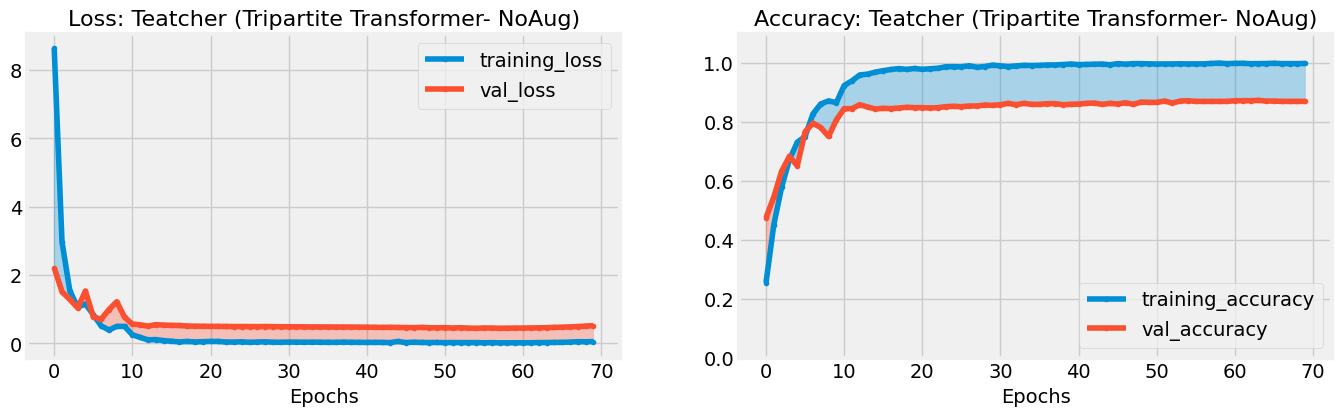

In [ ]:
plot_training_curves(history, 'Teatcher (Tripartite Transformer- NoAug)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 53s 256ms/step - accuracy: 0.2898 - top5-acc: 0.6625 - Brier score: 19.4695 - auc: 0.6688 - student_loss: 3.9307 - distillation_loss: 14.2989 - val_accuracy: 0.5129 - val_top5-acc: 0.8530 - val_Brier score: 2.7742 - val_auc: 0.8302 - val_student_loss: 1.6912 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 27s 237ms/step - accuracy: 0.4767 - top5-acc: 0.8221 - Brier score: 12.4747 - auc: 0.7649 - student_loss: 1.8699 - distillation_loss: 7.8055 - val_accuracy: 0.5903 - val_top5-acc: 0.8676 - val_Brier score: 2.0407 - val_auc: 0.8477 - val_student_loss: 1.4654 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 27s 236ms/step - accuracy: 0.5626 - top5-acc: 0.8833 - Brier score: 11.7871 - auc: 0.7961 - student_loss: 1.4448 - distillation_loss: 6.6152 - val_accuracy: 0.6117 - val_top5-acc: 0.8878 - val_Brier score: 3.2383 - val_auc: 0.8520 - val_student_loss: 1.4410 - lr: 0.0010
Epoch 4/100
112/112 [

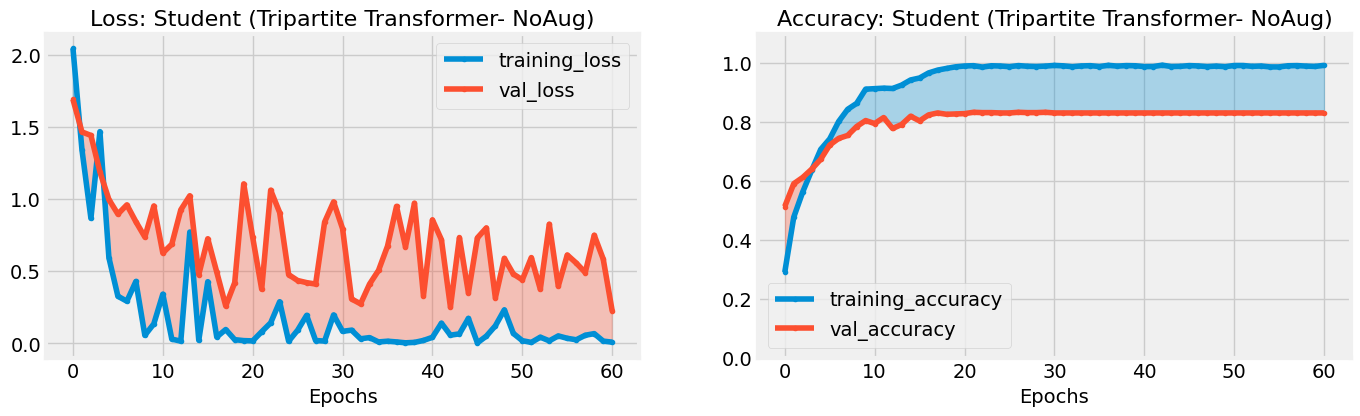

In [ ]:
plot_training_curves(history, 'Student (Tripartite Transformer- NoAug)', model_name='student')

### ▶ AugMix







In [ ]:
history = run_experiment(augmix_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 95s 647ms/step - loss: 7.8486 - accuracy: 0.1902 - top5-acc: 0.5463 - Brier score: 51.0599 - auc: 0.6121 - val_loss: 2.6098 - val_accuracy: 0.3288 - val_top5-acc: 0.7003 - val_Brier score: 12.8770 - val_auc: 0.7243 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 75s 653ms/step - loss: 2.8977 - accuracy: 0.2856 - top5-acc: 0.6613 - Brier score: 14.7192 - auc: 0.6895 - val_loss: 1.8113 - val_accuracy: 0.4388 - val_top5-acc: 0.7879 - val_Brier score: 3.4957 - val_auc: 0.7971 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 76s 656ms/step - loss: 2.1185 - accuracy: 0.3454 - top5-acc: 0.7208 - Brier score: 13.2971 - auc: 0.7302 - val_loss: 1.9232 - val_accuracy: 0.4714 - val_top5-acc: 0.8361 - val_Brier score: 5.7723 - val_auc: 0.8162 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 76s 661ms/step - loss: 1.8080 - accuracy: 0.4010 - top5-acc: 0.7621 - Brier score: 19.5047 - auc: 

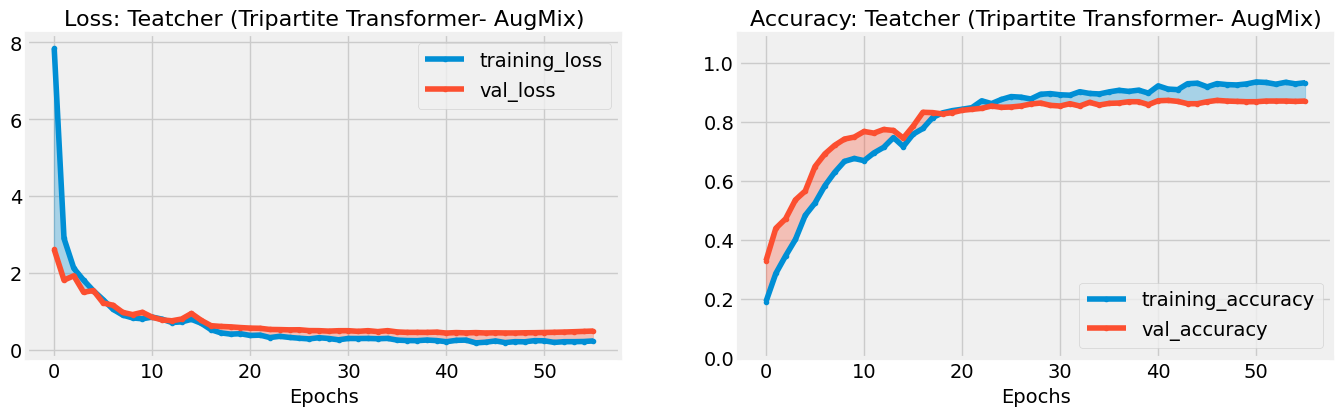

In [ ]:
plot_training_curves(history, 'Teatcher (Tripartite Transformer- AugMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(augmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 94s 599ms/step - accuracy: 0.2615 - top5-acc: 0.6271 - Brier score: 24.7764 - auc: 0.6617 - student_loss: 4.4095 - distillation_loss: 22.3105 - val_accuracy: 0.4837 - val_top5-acc: 0.8193 - val_Brier score: 12.6383 - val_auc: 0.7938 - val_student_loss: 1.9160 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 76s 656ms/step - accuracy: 0.4270 - top5-acc: 0.7834 - Brier score: 24.0751 - auc: 0.7487 - student_loss: 2.2843 - distillation_loss: 14.1683 - val_accuracy: 0.5589 - val_top5-acc: 0.8114 - val_Brier score: 10.2234 - val_auc: 0.8114 - val_student_loss: 1.1021 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 75s 657ms/step - accuracy: 0.4722 - top5-acc: 0.8336 - Brier score: 23.8944 - auc: 0.7768 - student_loss: 1.9021 - distillation_loss: 11.8281 - val_accuracy: 0.5982 - val_top5-acc: 0.8967 - val_Brier score: 13.1200 - val_auc: 0.8376 - val_student_loss: 1.4747 - lr: 0.0010
Epoch 4/100
112/

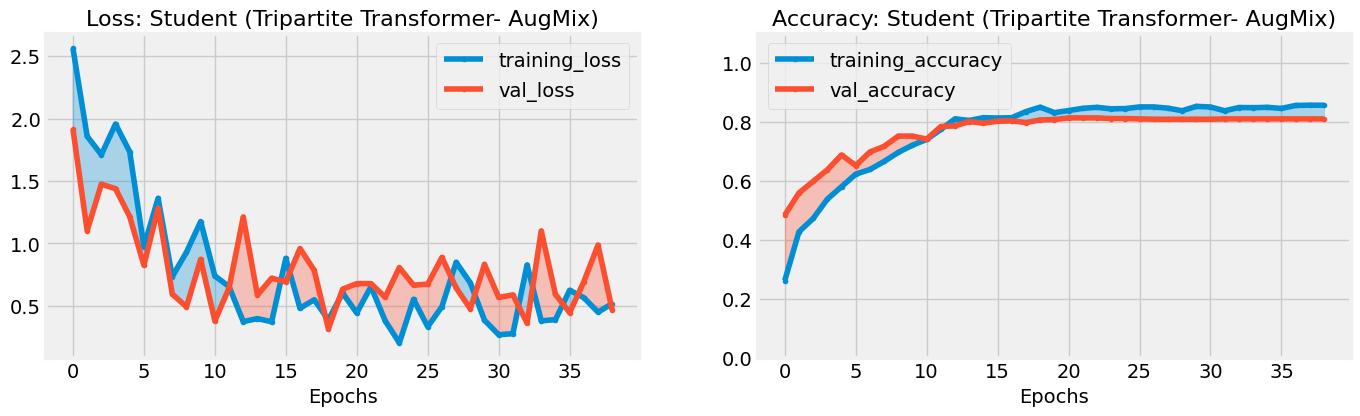

In [ ]:
plot_training_curves(history, 'Student (Tripartite Transformer- AugMix)', model_name='student')

### ▶ CutMix







In [ ]:
history = run_experiment(cutmix_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 55s 297ms/step - loss: 8.5389 - accuracy: 0.1515 - top5-acc: 0.4955 - Brier score: 52.9927 - auc: 0.5878 - val_loss: 2.9481 - val_accuracy: 0.1919 - val_top5-acc: 0.4837 - val_Brier score: 3.8590 - val_auc: 0.6058 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 32s 271ms/step - loss: 3.1947 - accuracy: 0.1866 - top5-acc: 0.5516 - Brier score: 7.5718 - auc: 0.6270 - val_loss: 2.3307 - val_accuracy: 0.2918 - val_top5-acc: 0.6465 - val_Brier score: 1.0382 - val_auc: 0.7131 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 32s 272ms/step - loss: 2.5537 - accuracy: 0.2104 - top5-acc: 0.5845 - Brier score: 6.4877 - auc: 0.6489 - val_loss: 2.1439 - val_accuracy: 0.3513 - val_top5-acc: 0.6981 - val_Brier score: 1.6483 - val_auc: 0.7299 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 32s 272ms/step - loss: 2.4002 - accuracy: 0.2399 - top5-acc: 0.6232 - Brier score: 8.1684 - auc: 0.66

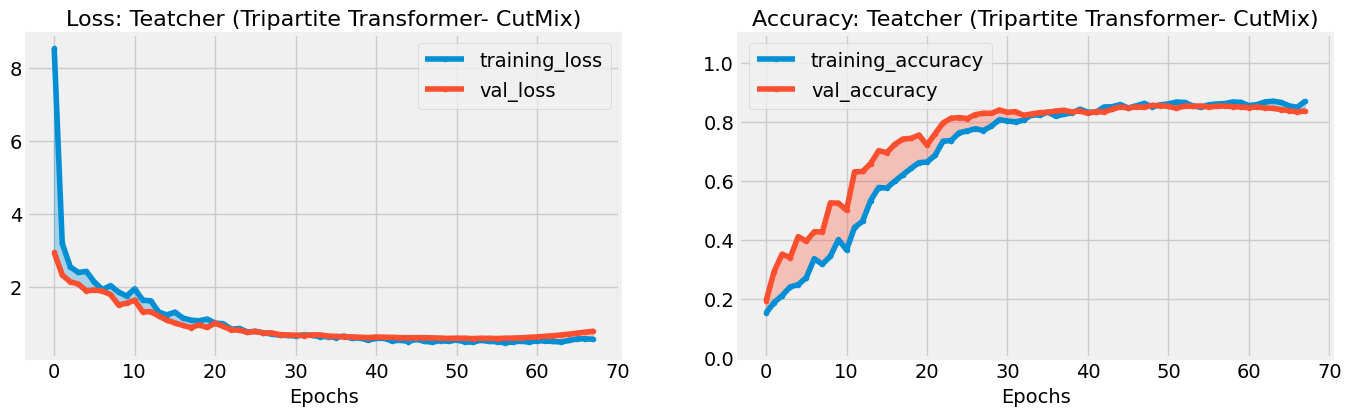

In [ ]:
plot_training_curves(history, 'Teatcher (Tripartite Transformer- CutMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(cutmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 54s 254ms/step - accuracy: 0.1658 - top5-acc: 0.5421 - Brier score: 8.4126 - auc: 0.6229 - student_loss: 3.6543 - distillation_loss: 5.3090 - val_accuracy: 0.3131 - val_top5-acc: 0.7037 - val_Brier score: 0.3808 - val_auc: 0.7544 - val_student_loss: 2.3522 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 28s 235ms/step - accuracy: 0.2326 - top5-acc: 0.6420 - Brier score: 1.7816 - auc: 0.6839 - student_loss: 2.3954 - distillation_loss: 2.4297 - val_accuracy: 0.3872 - val_top5-acc: 0.7778 - val_Brier score: 0.7528 - val_auc: 0.7955 - val_student_loss: 1.9423 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 28s 235ms/step - accuracy: 0.3246 - top5-acc: 0.7337 - Brier score: 2.0355 - auc: 0.7248 - student_loss: 2.1322 - distillation_loss: 2.1464 - val_accuracy: 0.4826 - val_top5-acc: 0.8328 - val_Brier score: 0.7224 - val_auc: 0.8315 - val_student_loss: 2.0716 - lr: 0.0010
Epoch 4/100
112/112 [====

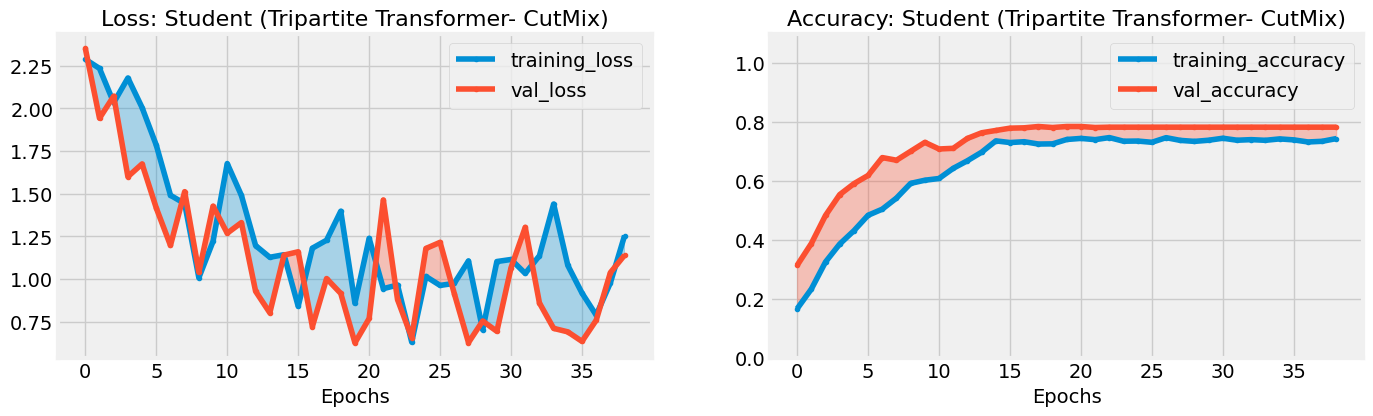

In [ ]:
plot_training_curves(history, 'Student (Tripartite Transformer- CutMix)', model_name='student')

### ▶ MixUp







In [ ]:
history = run_experiment(mixup_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 55s 298ms/step - loss: 7.5282 - accuracy: 0.1922 - top5-acc: 0.5617 - Brier score: 56.8366 - auc: 0.5982 - val_loss: 2.0652 - val_accuracy: 0.3704 - val_top5-acc: 0.7587 - val_Brier score: 2.7499 - val_auc: 0.7740 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 33s 274ms/step - loss: 2.6606 - accuracy: 0.2955 - top5-acc: 0.6818 - Brier score: 9.9209 - auc: 0.6508 - val_loss: 2.0583 - val_accuracy: 0.3827 - val_top5-acc: 0.7688 - val_Brier score: 1.1607 - val_auc: 0.7802 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 33s 274ms/step - loss: 2.2514 - accuracy: 0.3521 - top5-acc: 0.7337 - Brier score: 8.2284 - auc: 0.6766 - val_loss: 1.8316 - val_accuracy: 0.4860 - val_top5-acc: 0.7912 - val_Brier score: 2.6165 - val_auc: 0.7952 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 32s 270ms/step - loss: 1.9851 - accuracy: 0.4133 - top5-acc: 0.7724 - Brier score: 7.6435 - auc: 0.68

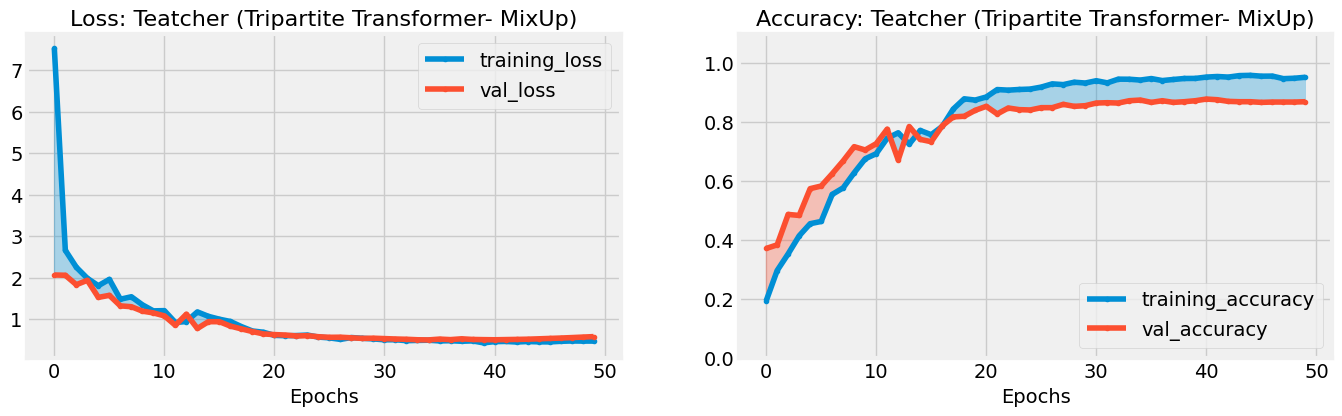

In [ ]:
plot_training_curves(history, 'Teatcher (Tripartite Transformer- MixUp)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(mixup_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 54s 255ms/step - accuracy: 0.1838 - top5-acc: 0.5752 - Brier score: 16.9648 - auc: 0.6399 - student_loss: 4.0113 - distillation_loss: 7.7287 - val_accuracy: 0.2941 - val_top5-acc: 0.7318 - val_Brier score: 0.2988 - val_auc: 0.7541 - val_student_loss: 2.3805 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 28s 236ms/step - accuracy: 0.2632 - top5-acc: 0.6953 - Brier score: 2.4610 - auc: 0.6952 - student_loss: 2.3789 - distillation_loss: 2.3977 - val_accuracy: 0.3973 - val_top5-acc: 0.7811 - val_Brier score: 0.4527 - val_auc: 0.7937 - val_student_loss: 2.0242 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 28s 228ms/step - accuracy: 0.3572 - top5-acc: 0.7626 - Brier score: 2.4942 - auc: 0.7158 - student_loss: 2.1194 - distillation_loss: 2.0703 - val_accuracy: 0.4366 - val_top5-acc: 0.7935 - val_Brier score: 0.9756 - val_auc: 0.7919 - val_student_loss: 1.9378 - lr: 0.0010
Epoch 4/100
112/112 [===

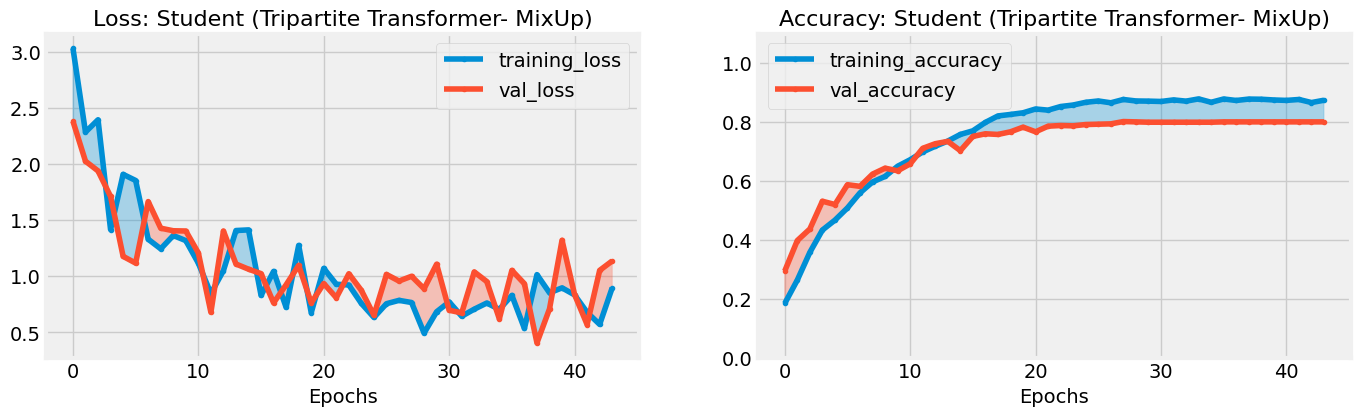

In [ ]:
plot_training_curves(history, 'Student (Tripartite Transformer- MixUp)', model_name='student')

### ▶ AugPip







In [ ]:
history = run_experiment(augpip_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 99s 684ms/step - loss: 7.8784 - accuracy: 0.1240 - top5-acc: 0.4574 - Brier score: 36.1774 - auc: 0.5548 - val_loss: 2.4982 - val_accuracy: 0.2155 - val_top5-acc: 0.5960 - val_Brier score: 1.3334 - val_auc: 0.6626 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 80s 698ms/step - loss: 2.7186 - accuracy: 0.1285 - top5-acc: 0.4997 - Brier score: 1.9095 - auc: 0.5754 - val_loss: 2.6383 - val_accuracy: 0.2043 - val_top5-acc: 0.5679 - val_Brier score: 1.1394 - val_auc: 0.6602 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 80s 697ms/step - loss: 2.7727 - accuracy: 0.1299 - top5-acc: 0.4579 - Brier score: 1.3565 - auc: 0.5596 - val_loss: 2.5620 - val_accuracy: 0.1672 - val_top5-acc: 0.4938 - val_Brier score: 0.3955 - val_auc: 0.6020 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 81s 700ms/step - loss: 2.6674 - accuracy: 0.1442 - top5-acc: 0.5093 - Brier score: 1.2666 - auc: 0.57

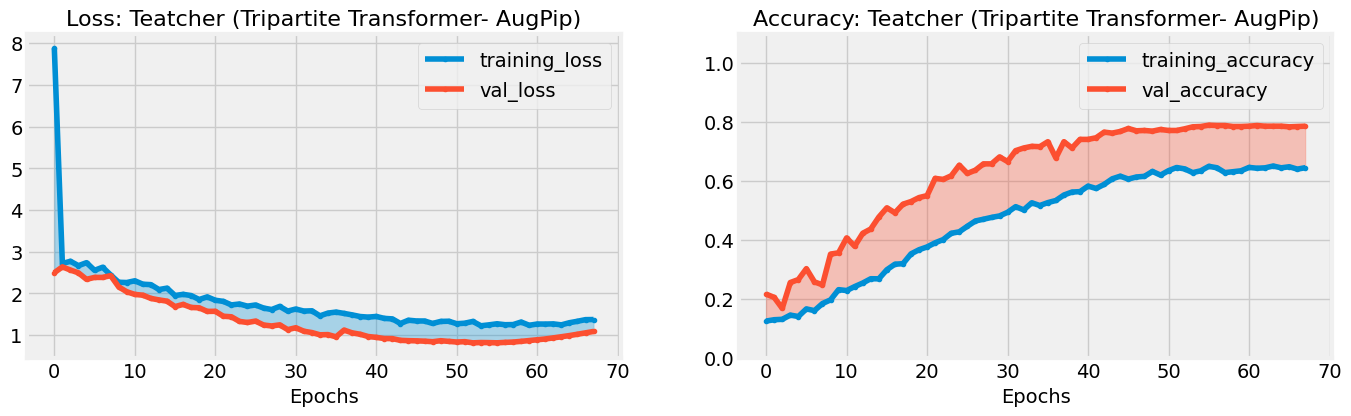

In [ ]:
plot_training_curves(history, 'Teatcher (Tripartite Transformer- AugPip)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(augpip_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 99s 647ms/step - accuracy: 0.1336 - top5-acc: 0.4955 - Brier score: 9.9612 - auc: 0.5931 - student_loss: 3.9176 - distillation_loss: 4.6702 - val_accuracy: 0.2245 - val_top5-acc: 0.6813 - val_Brier score: 0.1651 - val_auc: 0.7106 - val_student_loss: 2.5454 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 81s 698ms/step - accuracy: 0.1860 - top5-acc: 0.6167 - Brier score: 0.7824 - auc: 0.6560 - student_loss: 2.4791 - distillation_loss: 0.9624 - val_accuracy: 0.2896 - val_top5-acc: 0.7273 - val_Brier score: 0.2466 - val_auc: 0.7631 - val_student_loss: 2.3077 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 80s 694ms/step - accuracy: 0.2180 - top5-acc: 0.6594 - Brier score: 0.8403 - auc: 0.6721 - student_loss: 2.3729 - distillation_loss: 0.8730 - val_accuracy: 0.3939 - val_top5-acc: 0.7890 - val_Brier score: 0.3867 - val_auc: 0.7920 - val_student_loss: 2.1570 - lr: 0.0010
Epoch 4/100
112/112 [====

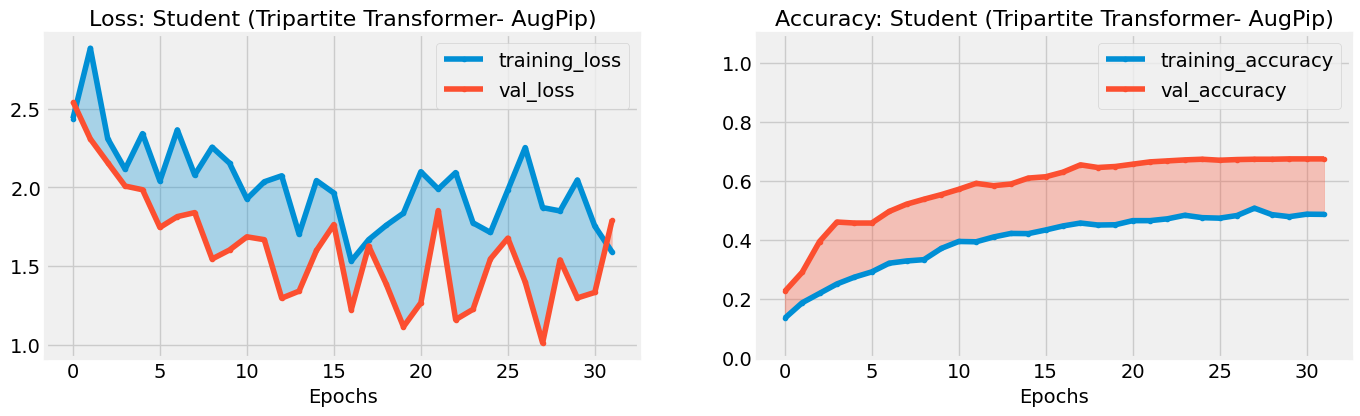

In [ ]:
plot_training_curves(history, 'Student (Tripartite Transformer- AugPip)', model_name='student')

### ▶ AugPip v2







In [ ]:
##### NEW ########
import random
def aug_pipeline_v2(samples):
    samples = augmix(samples, training=True)
    r = random.randint(0, 1)
    if(r>0.5):
      samples = mixup(samples, training=True)
    else:
      samples = cutmix(samples, training=True)
    return samples
#AugPip
augpip_ds_v2 = train_ds.shuffle(1000).map(to_dict)
augpip_ds_v2 = augpip_ds_v2.map(aug_pipeline_v2)
augpip_ds_v2 = augpip_ds_v2.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augpip_ds_v2 = augpip_ds_v2.prefetch(AUTOTUNE) #Use this for fit

In [ ]:
history = run_experiment(augpip_ds_v2, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 100s 691ms/step - loss: 7.7535 - accuracy: 0.1192 - top5-acc: 0.4473 - Brier score: 33.5808 - auc: 0.5648 - val_loss: 2.5279 - val_accuracy: 0.2020 - val_top5-acc: 0.5634 - val_Brier score: 1.3937 - val_auc: 0.6510 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 81s 708ms/step - loss: 2.8627 - accuracy: 0.1510 - top5-acc: 0.4966 - Brier score: 3.2427 - auc: 0.5926 - val_loss: 2.2477 - val_accuracy: 0.2772 - val_top5-acc: 0.6846 - val_Brier score: 0.7768 - val_auc: 0.7208 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 80s 697ms/step - loss: 2.4856 - accuracy: 0.1768 - top5-acc: 0.5421 - Brier score: 2.8701 - auc: 0.6256 - val_loss: 2.2475 - val_accuracy: 0.2896 - val_top5-acc: 0.6914 - val_Brier score: 0.8188 - val_auc: 0.7307 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 81s 706ms/step - loss: 2.3973 - accuracy: 0.1914 - top5-acc: 0.5673 - Brier score: 3.4340 - auc: 0.6

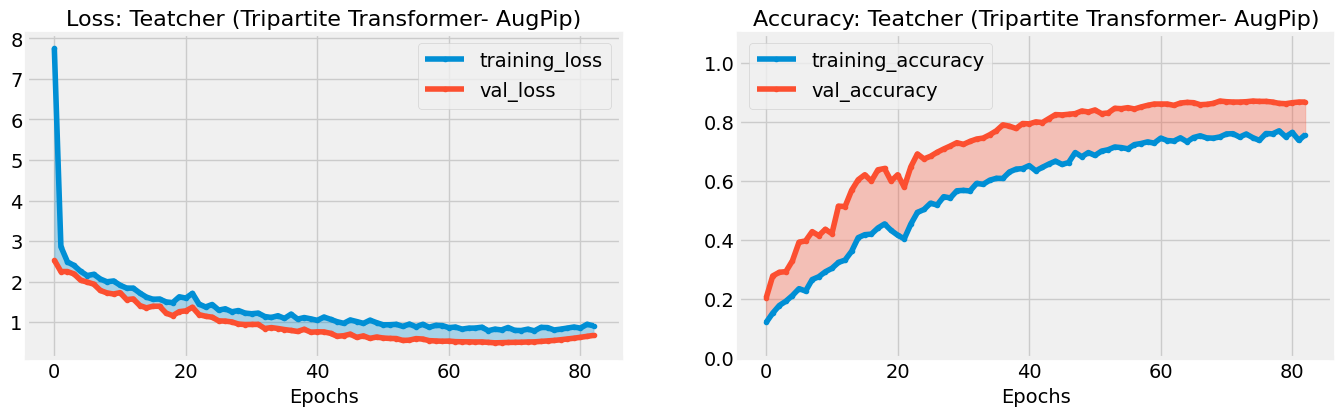

In [ ]:
plot_training_curves(history, 'Teatcher (Tripartite Transformer- AugPip)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(augpip_ds_v2, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 99s 643ms/step - accuracy: 0.1582 - top5-acc: 0.5443 - Brier score: 6.4272 - auc: 0.6172 - student_loss: 3.4764 - distillation_loss: 4.4054 - val_accuracy: 0.3513 - val_top5-acc: 0.7497 - val_Brier score: 0.3278 - val_auc: 0.7722 - val_student_loss: 2.3781 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 80s 692ms/step - accuracy: 0.2306 - top5-acc: 0.6378 - Brier score: 1.5729 - auc: 0.6803 - student_loss: 2.4026 - distillation_loss: 2.1292 - val_accuracy: 0.4164 - val_top5-acc: 0.7969 - val_Brier score: 0.6955 - val_auc: 0.7989 - val_student_loss: 1.7222 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 80s 695ms/step - accuracy: 0.2974 - top5-acc: 0.7158 - Brier score: 1.7099 - auc: 0.7218 - student_loss: 2.1874 - distillation_loss: 1.8454 - val_accuracy: 0.5039 - val_top5-acc: 0.8429 - val_Brier score: 0.7296 - val_auc: 0.8415 - val_student_loss: 2.0332 - lr: 0.0010
Epoch 4/100
112/112 [====

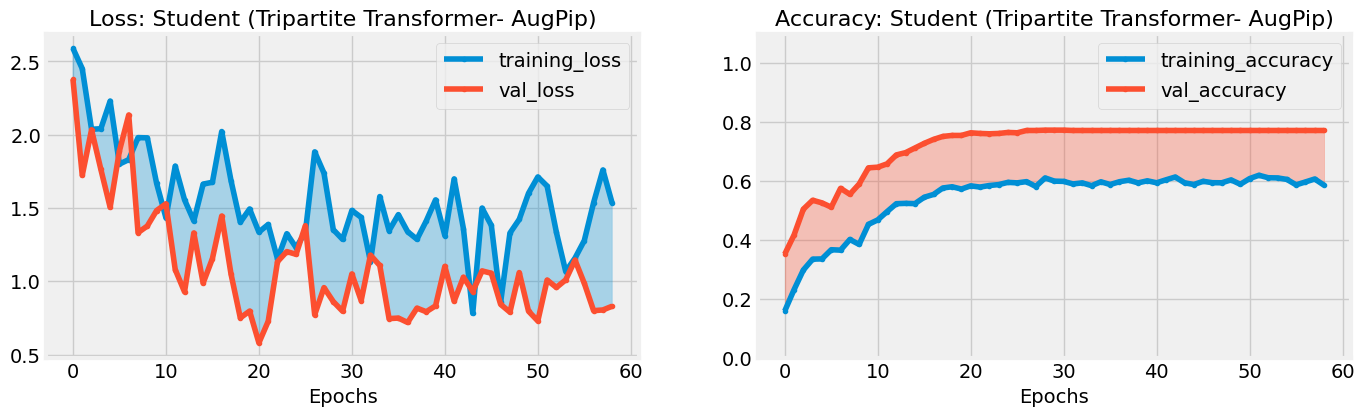

In [ ]:
plot_training_curves(history, 'Student (Tripartite Transformer- AugPip)', model_name='student')



---

##⏰ Flush

In [ ]:
del history
del transformer_student
del transformer_teacher



---

